# Переобучение. Регуляризация в линейной регрессии.

In [1]:
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt

## Переобучение 
В машинном обучении часто говорят об *обобщающей способности модели*, то есть о способности модели работать на новых, тестовых данных хорошо. Если модель будет идеально предсказывать выборку, на которой она обучалась, но при этом просто ее запомнит, не \"вытащив\" из данных никакой закономерности, от нее будет мало толку. Такую модель называет *переобученной*: она слишком подстроилась под обучающие примеры, не выявив никакой полезной закономерности, которая позволила бы ей совершать хорошие предсказания на данных, которые она ранее не видела.

### Пример 1. 
Рассмотрим пример переобучения на сгенерированных синтетических данных. Рассмотрим зависимость $y(x) = \cos(1.5\pi x)$, $y$ - целевая переменная, а $x$ - объект (просто число от 0 до 1). В жизни мы наблюдаем какое-то конечно количество пар объект-таргет, поэтому смоделируем это, взяв 30 случайных точек $x_i$ в отрезке $[0;1]$. Более того, в реальной жизни целевая переменная может быть зашумленной (измерения в жизни не всегда точны), смоделируем это, зашумив значение функции нормальным шумом: $\tilde{y}_i = y(x_i) + \mathcal{N}(0, 0.1)$.

Попытаемся обучить три разных линейных модели: признаки для первой &mdash;  $\\{x\\}$, для второй &mdash; $\\{x, x^2, x^3, x^4\\}$, для третьей &mdash; ${x, \dots, x^{20}}$.

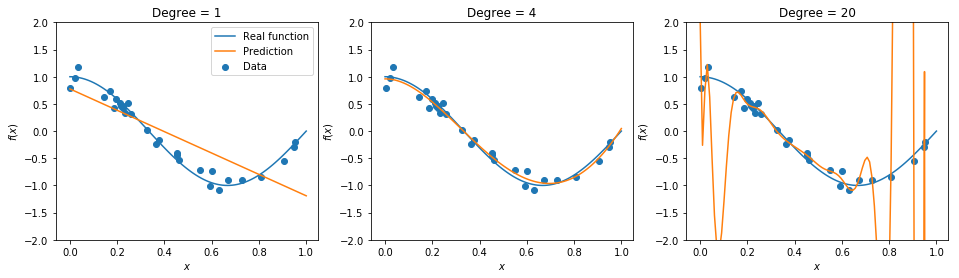

In [2]:
from sklearn.linear_model import LinearRegression

np.random.seed(36)
x = np.linspace(0, 1, 100)
y = np.cos(1.5 * np.pi * x)

x_objects = np.random.uniform(0, 1, size=30)
y_objects = np.cos(1.5 * np.pi * x_objects) + np.random.normal(scale=0.1, size=x_objects.shape)

from sklearn.preprocessing import PolynomialFeatures
fig, axs = plt.subplots(figsize=(16, 4), ncols=3)
for i, degree in enumerate([1, 4, 20]):
    X_objects = PolynomialFeatures(degree).fit_transform(x_objects[:, None])
    X = PolynomialFeatures(degree).fit_transform(x[:, None])
    regr = LinearRegression().fit(X_objects, y_objects)
    y_pred = regr.predict(X)
    axs[i].plot(x, y, label="Real function")
    axs[i].scatter(x_objects, y_objects, label="Data")
    axs[i].plot(x, y_pred, label="Prediction")
    if i == 0:
        axs[i].legend()
    axs[i].set_title("Degree = %d" % degree)
    axs[i].set_xlabel("$x$")
    axs[i].set_ylabel("$f(x)$")
    axs[i].set_ylim(-2, 2)

### Пример 2.  
Рассмотрим задачу предсказания опасности района. Загружаем [данные](http://archive.ics.uci.edu/ml/datasets/communities+and+crime): 

In [6]:
crm = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/communities/communities.data',
                header= None,na_values = '?')
#Загружаем и парсим имена признаков
import urllib
text = urllib.request.urlopen('https://archive.ics.uci.edu/ml/machine-learning-databases/communities/communities.names')
text = text.read()
text = str(text)
import re
colnames = re.findall(r"@attribute ([a-zA-Z1-90]*) [a-zA-Z]*\\n",text)
#Добавляем имена признаков
crm.columns = colnames

Выполним предобработку данных: выкинем ненужные колонки, заменим пропуски в данных средним значением признака:

In [7]:
#Выкидываем лишние ненужные колонки
crm = crm.drop(['state','county','community','communityname','fold'],1)
#Заполняем все пропуски в данных средними значениями для каждого признака
from sklearn import preprocessing
mis_replacer = preprocessing.Imputer(strategy="mean")
crm = pd.DataFrame(data=mis_replacer.fit_transform(crm),columns=crm.columns)
colnames = crm.columns
print(colnames)

Index(['population', 'householdsize', 'racepctblack', 'racePctWhite',
       'racePctAsian', 'racePctHisp', 'agePct12t21', 'agePct12t29',
       'agePct16t24', 'agePct65up',
       ...
       'LandArea', 'PopDens', 'PctUsePubTrans', 'PolicCars', 'PolicOperBudg',
       'LemasPctPolicOnPatr', 'LemasGangUnitDeploy', 'LemasPctOfficDrugUn',
       'PolicBudgPerPop', 'ViolentCrimesPerPop'],
      dtype='object', length=123)


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


Разделим выборку на обучающую и тестовую, обучим линейную регрессиию и выведем коэффициенты детерминации $R^2$ на обучающей и тестовой выборках.

P.S. В описании данных указано, что они отмасштабированы. 

In [11]:
X=crm.iloc[:, :-1].values
Y=crm.iloc[:, -1].values

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

[0.2  0.67 0.43 ... 0.23 0.19 0.48]


In [12]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()

lr.fit(X_train,y_train)

print(lr.score(X_train,y_train))
print(lr.score(X_test,y_test))

0.7127879770107748
-46.706809918629


#### Почему коэффициент $R^2$ отрицательный?  
Посторим таблицу весов линейной регрессии перед соответствующими признаками:

In [13]:
w = lr.coef_
w = pd.DataFrame({'Feature name':colnames[:-1],'Feature weight':w},columns = ['Feature name','Feature weight'])

Посмотрим на распределение весовых коэффициентов:

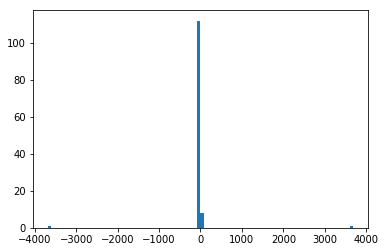

In [14]:
a=plt.hist(w['Feature weight'],bins=100)

У двух признаков огромные весовые коэффициенты, это может указывать на их сильную корреляцию (мультиколлинеарность).   

In [15]:
print(w.sort_values(by='Feature weight',ascending=True).head())
print(w.sort_values(by='Feature weight',ascending=True).tail())

          Feature name  Feature weight
103        PolicPerPop    -3670.630978
96        LemasSwornFT       -0.851627
98   LemasSwFTFieldOps       -0.569492
41         TotalPctDiv       -0.532823
121    PolicBudgPerPop       -0.411012
        Feature name  Feature weight
19         medFamInc        0.323237
38    MalePctDivorce        0.422140
58      PctRecImmig8        0.446751
64  PersPerOccupHous        0.672912
97   LemasSwFTPerPop     3671.132587


In [18]:
np.corrcoef(crm['PolicPerPop'],crm['LemasSwFTPerPop'])[0,1]

0.999993875767381

In [19]:
crm = crm.drop(['LemasSwFTPerPop'],1)
colnames  = crm.columns

In [20]:
X1=crm.iloc[:, :-1].values
Y1=crm.iloc[:, -1].values

X_train, X_test, y_train, y_test = train_test_split(X1, Y1, test_size=0.3, random_state=42)
lr.fit(X_train,y_train)

print(lr.score(X_train,y_train))
print(lr.score(X_test,y_test))

0.7101153630416851
0.6190220060336034


## Регуляризация
Один из способов бороться с большими коэффициентами в линейной модели - регуляризация. 

Ridge регрессия решает оптимизационную задачу :
$$\frac{1}{N} \sum_{i=1}^N ((w, x_i) - y_i)^2 + \alpha ||w||_2^2 \to \min_{w}.$$

In [21]:
from sklearn.linear_model import Ridge

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)
ridge_model = Ridge(alpha=0.1)
ridge_model.fit(X_train,y_train)
print(ridge_model.score(X_train,y_train))
print(ridge_model.score(X_test,y_test))

0.7091960929929717
0.6224854859548641


Lasso регрессия решает оптимизационную задачу :
$$\frac{1}{l} \sum_{i=1}^l (<w, x_i> - y_i)^2 + \alpha ||w||_1 \to \min_{w}.$$
Если $\alpha$ достаточно велико, то часть найденных коэффициентов $w_j$ зануляется.

In [22]:
from sklearn.linear_model import Lasso

lasso_model = Lasso(alpha = 1e-4)
lasso_model.fit(X_train, y_train)
print(lasso_model.score(X_train, y_train))
print(lasso_model.score(X_test, y_test))

0.6989238489130853
0.630889829250866


In [23]:
w['lasso_coef']=lasso_model.coef_

In [24]:
print(w.sort_values(by='Feature weight',ascending=True).head())
print(w.sort_values(by='Feature weight',ascending=True).tail())

          Feature name  Feature weight  lasso_coef
103        PolicPerPop    -3670.630978    0.000000
96        LemasSwornFT       -0.851627   -0.000000
98   LemasSwFTFieldOps       -0.569492    0.000000
41         TotalPctDiv       -0.532823   -0.000000
121    PolicBudgPerPop       -0.411012   -0.044954
        Feature name  Feature weight  lasso_coef
19         medFamInc        0.323237    0.013308
38    MalePctDivorce        0.422140    0.135180
58      PctRecImmig8        0.446751    0.088191
64  PersPerOccupHous        0.672912    0.158505
97   LemasSwFTPerPop     3671.132587    0.029360


### Валидация модели. 
Рассмотрим несколько способов кросс-валидации: 
1. ### [ShuffleSplit](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.ShuffleSplit.html)

In [25]:
from sklearn.model_selection import ShuffleSplit
cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=23)

for train, test in cv.split(X1):
    lr.fit(X1[train], Y1[train])
    print("Train score:",lr.score(X1[train],Y1[train]),"Test score:",lr.score(X1[test],Y1[test]))

Train score: 0.689072047004425 Test score: 0.6653616789801204
Train score: 0.7243301233878414 Test score: 0.5448944434827208
Train score: 0.7171768355835958 Test score: 0.6143006836202365
Train score: 0.7049472681196765 Test score: 0.6617691475031835
Train score: 0.7028740172192545 Test score: 0.6403551070552274


### 2. [KFold](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html) 
Выборка разбивается на $K$ (примерно) одинаковых блоков, каждый из которых поочередно выступает в качестве контрольной выборки, а оставшиеся $K-1$ — в качестве обучающей, после чего оценки качества усредняются:

$$Q_{K-fold}(X) = \frac{1}{K} \sum_{k=1}^K Q(X^k; a_{X \backslash X^k }),$$
где $X^k, k = \overline{1, K}$ — непересекающиеся блоки, на которые разбивается выборка $X$: $X = \sqcup_{k=1}^K X^k.$
![](http://scott.fortmann-roe.com/docs/docs/MeasuringError/crossvalidation.png)

In [26]:
from sklearn.model_selection import KFold

k_fold = KFold(5,shuffle =True,random_state=23)

for train, test in k_fold.split(X1):
    lr.fit(X1[train], Y1[train])
    print("Train score:",lr.score(X1[train],Y1[train]),"Test score:",lr.score(X1[test],Y1[test]))

Train score: 0.7033126874951293 Test score: 0.6280376570454835
Train score: 0.6872158417321755 Test score: 0.7022990759381901
Train score: 0.7010593222937433 Test score: 0.6662226151360804
Train score: 0.7161387038709354 Test score: 0.5603584671613191
Train score: 0.7229118971918679 Test score: 0.503510677680489


## Подбор параметров. 

In [27]:
from sklearn.model_selection import GridSearchCV

alphas = np.logspace(-2, 3, 20)
searcher = GridSearchCV(Ridge(), [{"alpha": alphas}], cv=10)
searcher.fit(X_train, y_train)

print(searcher.best_params_)

{'alpha': 4.281332398719392}


In [28]:
print(searcher.cv_results_)

{'mean_fit_time': array([0.00842619, 0.00513387, 0.00650892, 0.00519991, 0.00643613,
       0.00630043, 0.00730808, 0.00399959, 0.00639954, 0.00760071,
       0.00617225, 0.00766768, 0.00770524, 0.00501113, 0.00533814,
       0.00823324, 0.00639668, 0.00439906, 0.00500891, 0.00679944]), 'std_fit_time': array([1.25493810e-03, 1.59590504e-03, 2.07279662e-03, 1.83361281e-03,
       1.99209996e-03, 1.89976453e-03, 1.68498629e-03, 8.61281961e-07,
       1.96003395e-03, 1.20049434e-03, 1.89222574e-03, 1.04983479e-03,
       5.55328074e-03, 2.71821129e-03, 1.79005183e-03, 9.97609582e-04,
       1.95786016e-03, 1.20059675e-03, 1.61442478e-03, 1.83420347e-03]), 'mean_score_time': array([7.92336464e-04, 8.00156593e-04, 4.00018692e-04, 1.20024681e-03,
       9.97066498e-05, 2.00009346e-03, 8.00132751e-04, 1.60019398e-03,
       0.00000000e+00, 0.00000000e+00, 3.99947166e-04, 0.00000000e+00,
       4.18376923e-04, 1.20148659e-03, 2.40285397e-03, 2.99382210e-04,
       1.20034218e-03, 0.00000000e+0

Text(0, 0.5, 'CV score')

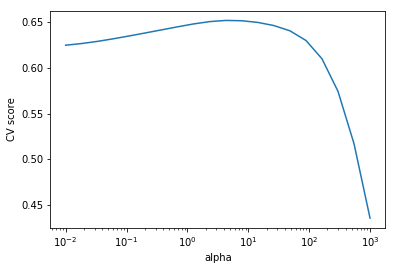

In [29]:
plt.plot(alphas, searcher.cv_results_["mean_test_score"])
plt.xscale("log")
plt.xlabel("alpha")
plt.ylabel("CV score")